In [46]:
import sys
sys.path.append('./lib/python3.8/site-packages')

# data prep

In [1]:
import gensim
import aquirdturtle_collapsible_headings
import pandas as pd
import numpy as np
import collections
import itertools
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import sklearn.model_selection
import torch
import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils.data
import collections
from collections import Counter

In [83]:
coupons = pd.read_parquet(r"C:\Users\Benedikt\Desktop\Mein Ordner\WI-INFO\Semester 1\ML for Marketing\Final\coupons.parquet", engine='pyarrow')
coupon_index = pd.read_parquet(r"C:\Users\Benedikt\Desktop\Mein Ordner\WI-INFO\Semester 1\ML for Marketing\Final\coupon_index.parquet", engine='pyarrow')
basket = pd.read_parquet(r"C:\Users\Benedikt\Desktop\Mein Ordner\WI-INFO\Semester 1\ML for Marketing\Final\baskets.parquet", engine='pyarrow')

In [84]:
basket = basket[basket['shopper'] < 2000]
basket = basket.merge(coupons, how = "outer")
basket = basket[basket['shopper'] < 2000]
basket['discount'] = basket['discount'].fillna(0)
basket['price'] = basket['price'].fillna(0)

# Price Elastics

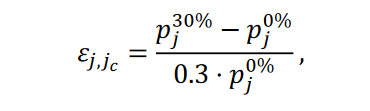

In [153]:
# median is same as in the given paper
def calc_elastics():
    elast = []
    total_basket_count = len(basket.groupby(['week', 'shopper']))

    for i in range(250):
        reg_price = basket[basket['product'] == i]
        reg_price_buy = len(reg_price[reg_price['discount'] == 0])
        all_discounts_offers = len(reg_price[reg_price['discount'] > 0])
        reg_price_offer = total_basket_count - all_discounts_offers
        reg_price_buy_rate = reg_price_buy / reg_price_offer
        discount_30 = reg_price[reg_price['discount'] == 30]
        discount_30_offer = len(discount_30)
        discount_30_buy = discount_30['price'].notnull().sum()
        discount_buy_rate = discount_30_buy / discount_30_offer
        elast.append((discount_buy_rate - reg_price_buy_rate) / (0.3 * reg_price_buy_rate))
    
    price_elastics = pd.DataFrame(elast)
    return price_elastics


def calc_week_elastics(week, duration):
    elast = []

    if week >= duration:
        basket_temp = basket[(week >= basket['week']) & (basket['week'] >= week - duration)]
        total_basket_count = len(basket_temp.groupby(['week', 'shopper']))
    else: raise ValueError('week[0] must be bigger than duration[1].')

    for i in range(250):
        reg_price = basket_temp[basket_temp['product'] == i]
        reg_price_buy = len(reg_price[reg_price['discount'] == 0])
        all_discounts_offers = len(reg_price[reg_price['discount'] > 0])
        reg_price_offer = total_basket_count - all_discounts_offers
        reg_price_buy_rate = reg_price_buy / reg_price_offer
        discount_30 = reg_price[reg_price['discount'] == 30]
        discount_30_offer = len(discount_30)
        discount_30_buy = discount_30['price'].notnull().sum()
        discount_30_buy_rate = discount_30_buy / discount_30_offer
        elast.append((discount_30_buy_rate - reg_price_buy_rate) / (0.3 * reg_price_buy_rate))
    
    week_price_elastics = pd.DataFrame(elast)
    return week_price_elastics

# coupon redemption rates

In [90]:
def calc_coupon_rates(basket, week, duration):
    if week >= duration:
        basket_temp = basket[(week >= basket['week']) & (basket['week'] >= week - duration)]
    else: raise ValueError('week[0] must be bigger than duration[1].')

    # coupon redemption likelihood by product
    coupons = basket_temp[basket_temp['discount'] > 0].copy()
    coupons.loc[(coupons['price'] != 0), 'redeemed']  = 1
    coupons['redeemed'] = coupons['redeemed'].fillna(0)

    redemption_rate = coupons.groupby(['product'])['redeemed'].mean()
    basket_temp = basket_temp.merge(redemption_rate, how = 'left', on = 'product')
    basket_temp = basket_temp.rename(columns = {'redeemed' : 'product_redemption_likelihood'})


    # coupon redemption likelihood by costumer & product
    costumer_redemption_rate = coupons.groupby(['shopper', 'product'])['redeemed'].mean()
    basket_temp = basket_temp.merge(costumer_redemption_rate, how = 'left', on = ['shopper', 'product'])
    basket_temp = basket_temp.rename(columns = {'redeemed' : 'shopper_product_discount_usage'})


    # only buy because of discount?
    buy_all = basket_temp.groupby(['shopper', 'product']).size()
    discount = coupons.groupby(['shopper', 'product']).size()
    discount_buy = discount / buy_all
    discount_buy = discount_buy.fillna(0)
    discount_buy = discount_buy.rename('discount_buy')
    basket_temp = basket_temp.merge(discount_buy, how = 'left', on = ['shopper', 'product'])
    
    return basket_temp